# CLAHE (Contrast Limited Adaptive Histogram Equalization) Demonstration

This notebook demonstrates the CLAHE algorithm step by step, showing the internal process of how CLAHE enhances image contrast while preventing over-amplification of noise.

## Import Required Libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

## Step 1: Load and Display Original Image

Image shape: (720, 1080)
Image dtype: uint8
Intensity range: [0, 255]


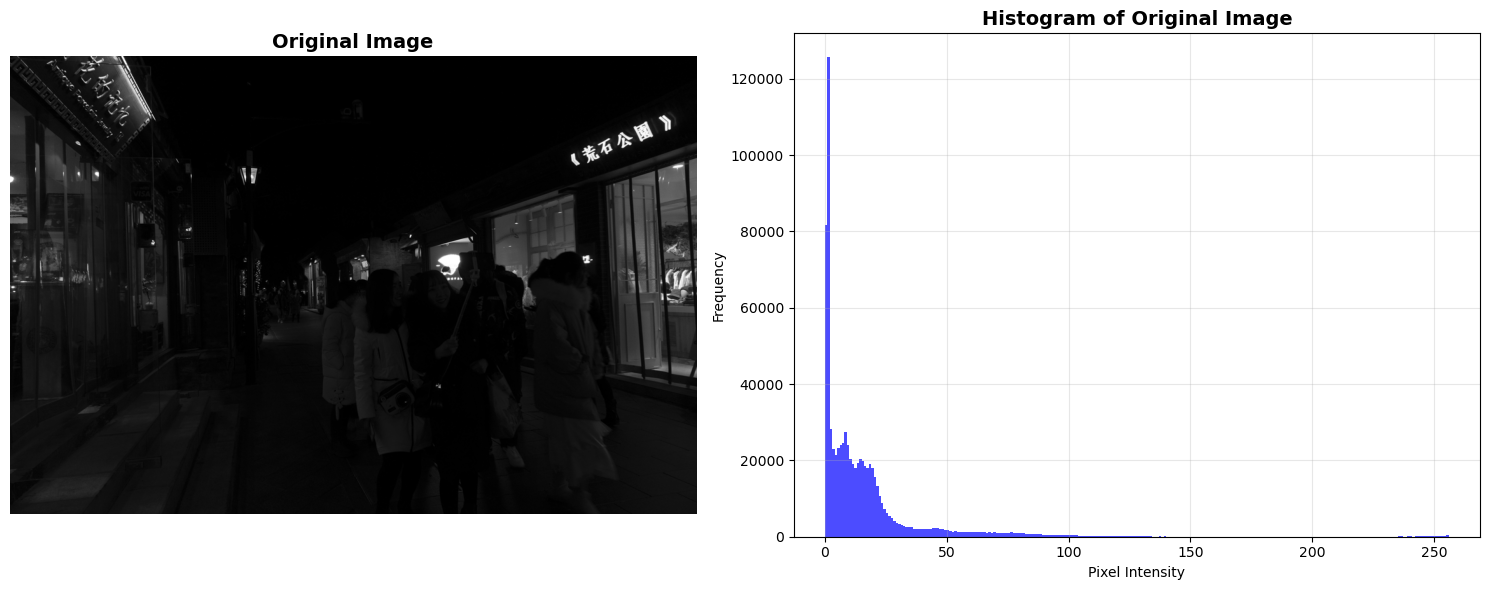

In [3]:
# Load the image in grayscale
image = cv2.imread('LL_1.png', cv2.IMREAD_GRAYSCALE)

if image is None:
    print("Error: Could not load image 'LL_1.png'")
else:
    print(f"Image shape: {image.shape}")
    print(f"Image dtype: {image.dtype}")
    print(f"Intensity range: [{image.min()}, {image.max()}]")
    
    # Display original image
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Histogram of original image
    axes[1].hist(image.ravel(), bins=256, range=[0, 256], color='blue', alpha=0.7)
    axes[1].set_title('Histogram of Original Image', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Pixel Intensity')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Step 2: Define CLAHE Parameters and Divide Image into Tiles

CLAHE Parameters:
  Tile Grid Size: (8, 8)
  Clip Limit: 2.0

Image dimensions: 720 x 1080
Each tile size: 90 x 135 pixels


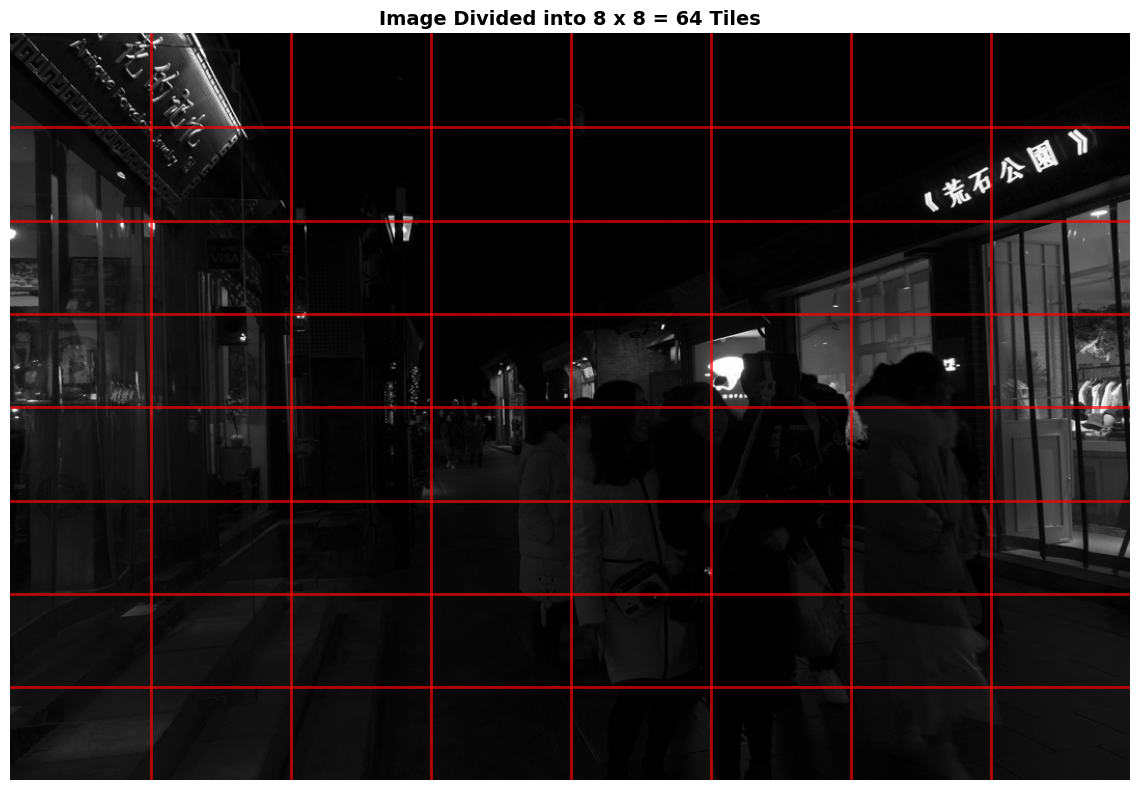

In [4]:
# CLAHE parameters
tile_size = (8, 8)  # Grid size for tiles
clip_limit = 2.0     # Contrast limit for limiting amplification

print(f"CLAHE Parameters:")
print(f"  Tile Grid Size: {tile_size}")
print(f"  Clip Limit: {clip_limit}")

# Calculate tile dimensions
height, width = image.shape
tile_height = height // tile_size[0]
tile_width = width // tile_size[1]

print(f"\nImage dimensions: {height} x {width}")
print(f"Each tile size: {tile_height} x {tile_width} pixels")

# Visualize tile division
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image, cmap='gray')

# Draw grid lines to show tiles
for i in range(1, tile_size[0]):
    ax.axhline(y=i * tile_height, color='red', linewidth=2, alpha=0.7)
for j in range(1, tile_size[1]):
    ax.axvline(x=j * tile_width, color='red', linewidth=2, alpha=0.7)

ax.set_title(f'Image Divided into {tile_size[0]} x {tile_size[1]} = {tile_size[0] * tile_size[1]} Tiles', 
             fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

## Step 3: Extract and Visualize Sample Tiles

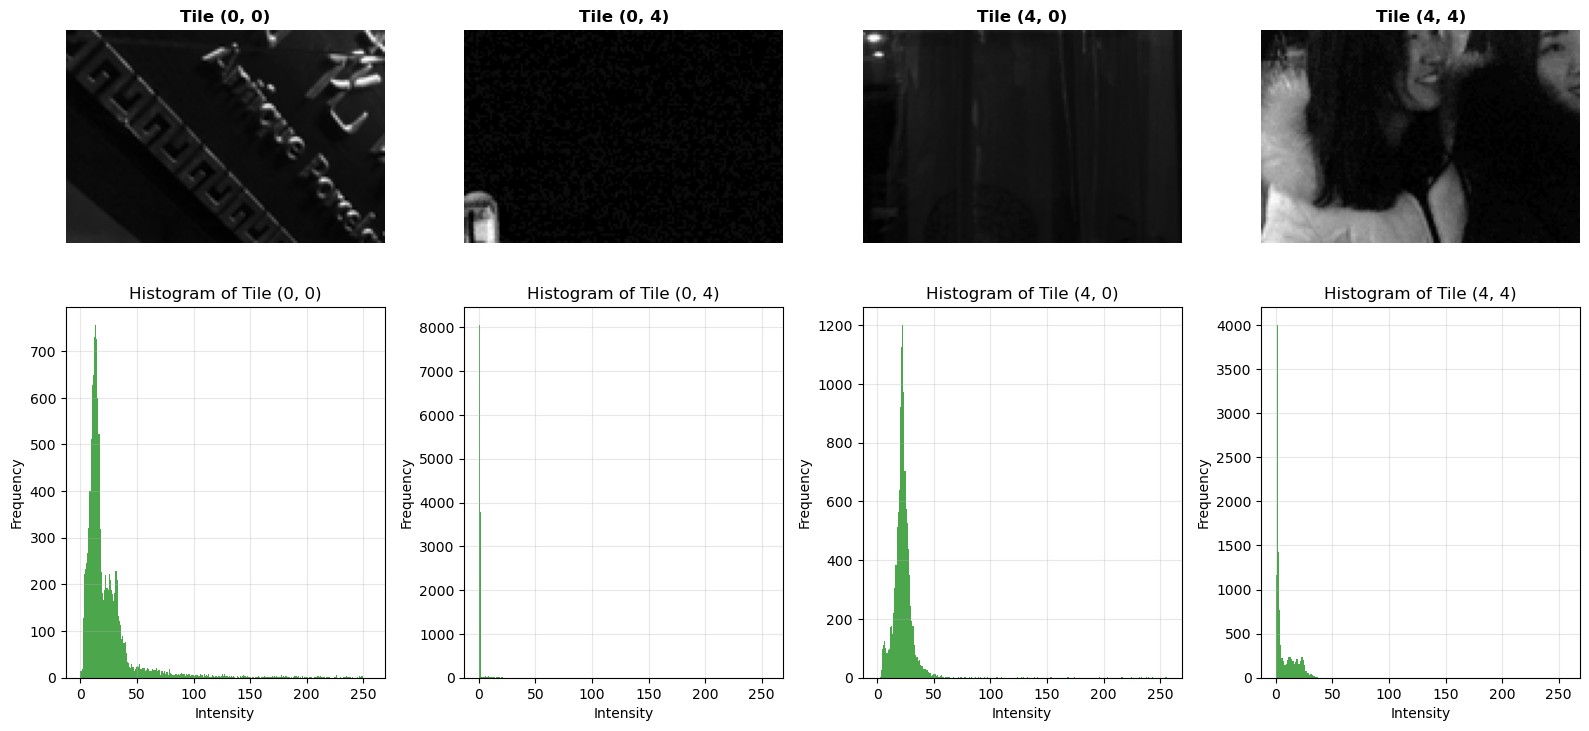

In [5]:
# Extract some sample tiles to visualize
sample_tiles = []
sample_positions = [(0, 0), (0, tile_size[1]//2), (tile_size[0]//2, 0), 
                    (tile_size[0]//2, tile_size[1]//2)]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, (i, j) in enumerate(sample_positions):
    # Extract tile
    y_start = i * tile_height
    y_end = (i + 1) * tile_height
    x_start = j * tile_width
    x_end = (j + 1) * tile_width
    
    tile = image[y_start:y_end, x_start:x_end]
    sample_tiles.append(tile)
    
    # Display tile
    axes[0, idx].imshow(tile, cmap='gray')
    axes[0, idx].set_title(f'Tile ({i}, {j})', fontweight='bold')
    axes[0, idx].axis('off')
    
    # Display histogram
    axes[1, idx].hist(tile.ravel(), bins=256, range=[0, 256], color='green', alpha=0.7)
    axes[1, idx].set_title(f'Histogram of Tile ({i}, {j})')
    axes[1, idx].set_xlabel('Intensity')
    axes[1, idx].set_ylabel('Frequency')
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4: Compute Histogram for Each Tile

Computed histograms for all 8 x 8 tiles


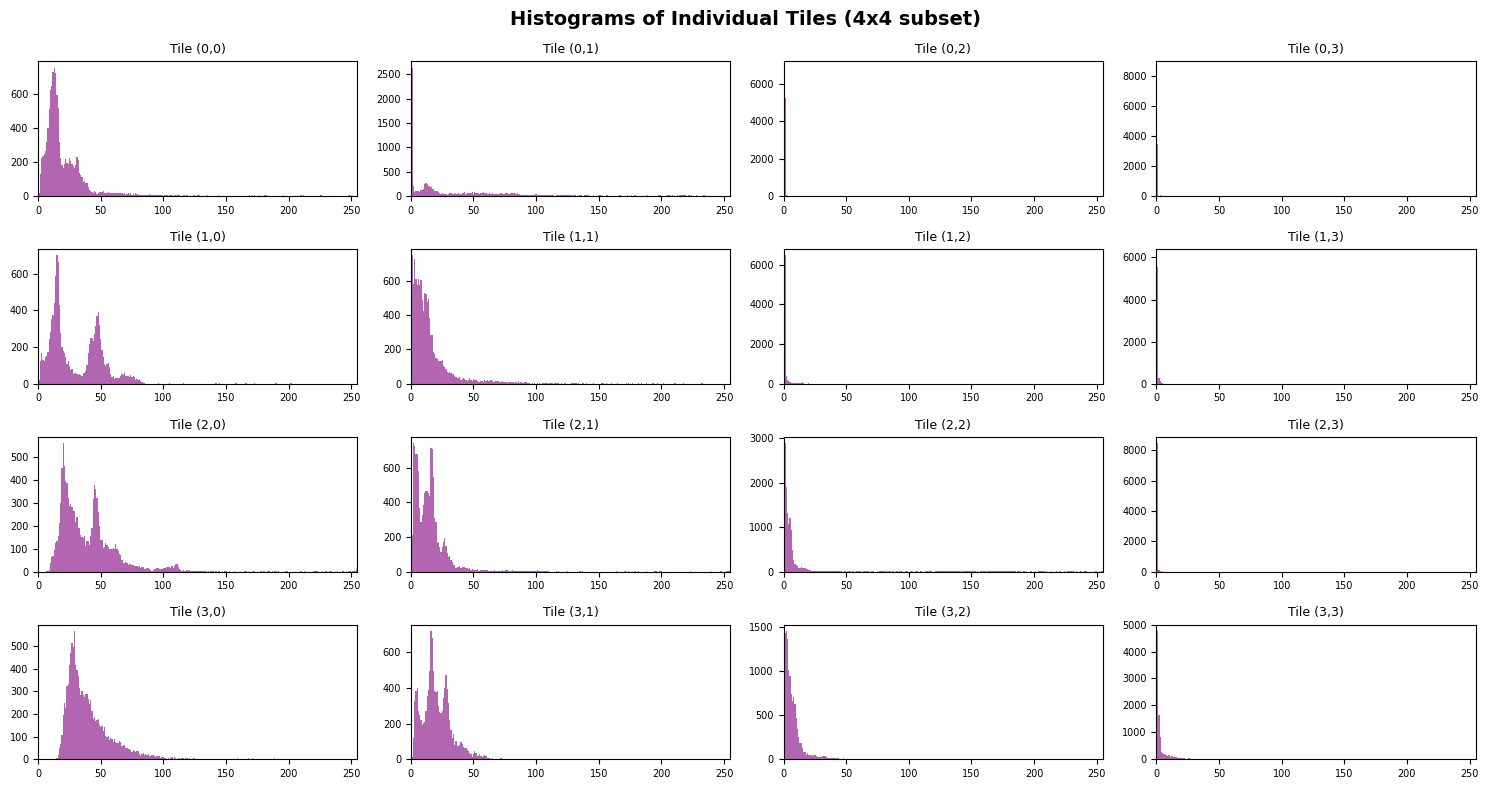

In [6]:
# Compute histograms for all tiles
tile_histograms = []

for i in range(tile_size[0]):
    row_histograms = []
    for j in range(tile_size[1]):
        # Extract tile
        y_start = i * tile_height
        y_end = (i + 1) * tile_height
        x_start = j * tile_width
        x_end = (j + 1) * tile_width
        
        tile = image[y_start:y_end, x_start:x_end]
        
        # Compute histogram
        hist, _ = np.histogram(tile, bins=256, range=[0, 256])
        row_histograms.append(hist)
    
    tile_histograms.append(row_histograms)

print(f"Computed histograms for all {tile_size[0]} x {tile_size[1]} tiles")

# Visualize histogram distribution across tiles
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(4, 4, figure=fig)

# Show a 4x4 subset of tile histograms
for i in range(min(4, tile_size[0])):
    for j in range(min(4, tile_size[1])):
        ax = fig.add_subplot(gs[i, j])
        ax.bar(range(256), tile_histograms[i][j], width=1, color='purple', alpha=0.6)
        ax.set_title(f'Tile ({i},{j})', fontsize=9)
        ax.set_xlim([0, 255])
        ax.tick_params(labelsize=7)

plt.suptitle('Histograms of Individual Tiles (4x4 subset)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 5: Apply Contrast Limiting (Clipping)

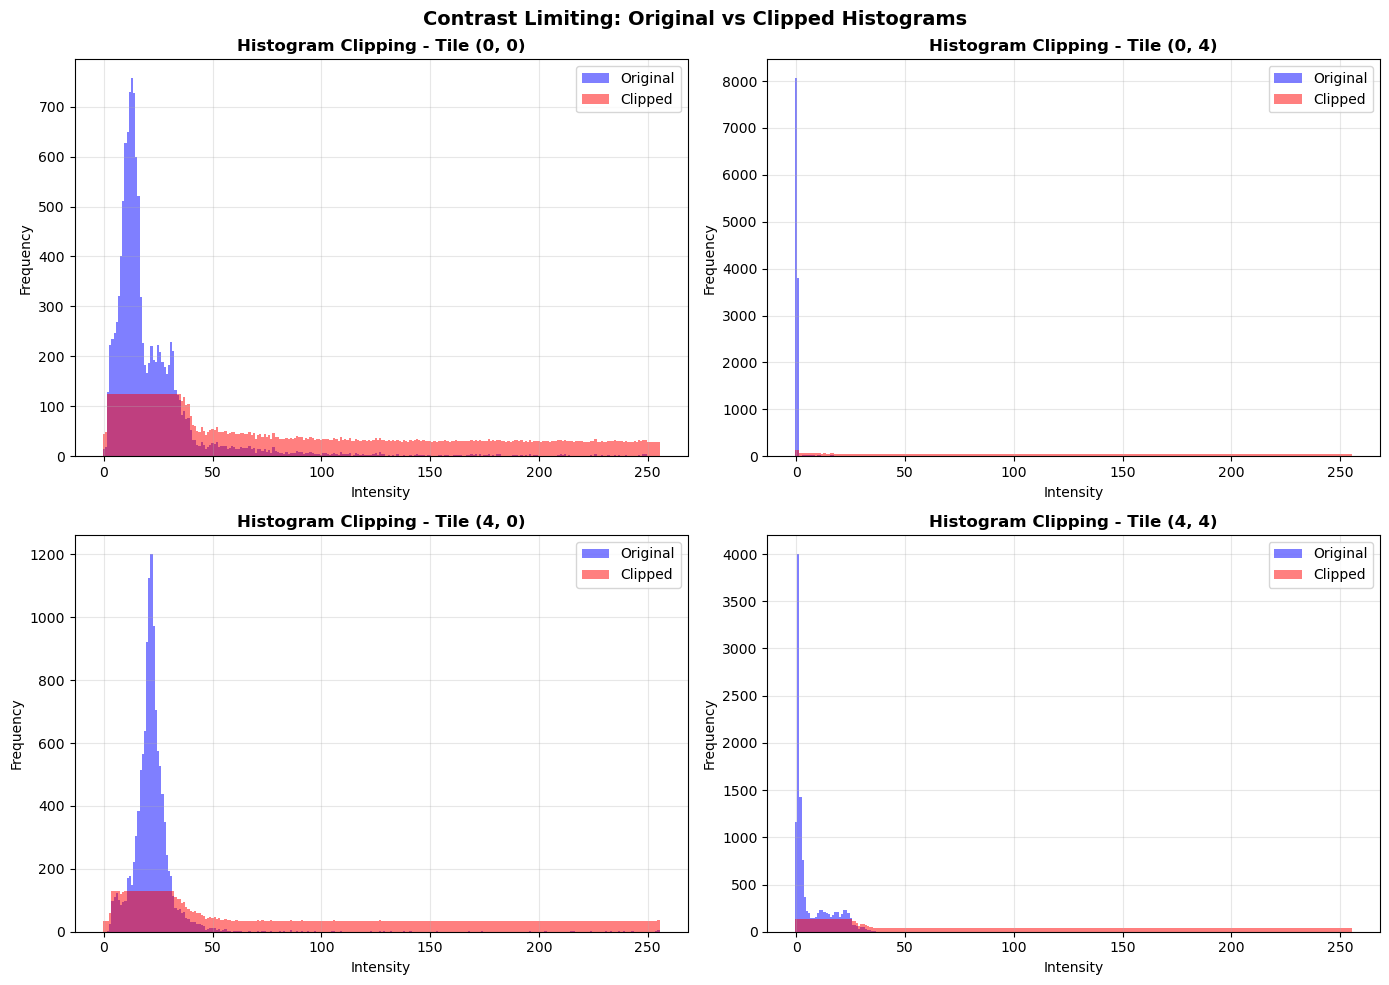

Clipping prevents over-amplification of contrast in regions with very few pixels.


In [7]:
# Apply contrast limiting to histograms
def clip_histogram(hist, clip_limit):
    """Clip histogram and redistribute excess pixels"""
    hist_clipped = hist.copy().astype(float)
    
    # Calculate clip limit based on tile size
    total_pixels = hist.sum()
    clip_threshold = (total_pixels / 256) * clip_limit
    
    # Clip histogram
    excess = 0
    for i in range(256):
        if hist_clipped[i] > clip_threshold:
            excess += hist_clipped[i] - clip_threshold
            hist_clipped[i] = clip_threshold
    
    # Redistribute excess uniformly
    redistribution = excess / 256
    hist_clipped += redistribution
    
    return hist_clipped

# Apply clipping to sample tiles
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (i, j) in enumerate(sample_positions[:4]):
    original_hist = tile_histograms[i][j]
    clipped_hist = clip_histogram(original_hist, clip_limit)
    
    # Plot both histograms
    x = np.arange(256)
    axes[idx].bar(x, original_hist, width=1, color='blue', alpha=0.5, label='Original')
    axes[idx].bar(x, clipped_hist, width=1, color='red', alpha=0.5, label='Clipped')
    axes[idx].set_title(f'Histogram Clipping - Tile ({i}, {j})', fontweight='bold')
    axes[idx].set_xlabel('Intensity')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Contrast Limiting: Original vs Clipped Histograms', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Clipping prevents over-amplification of contrast in regions with very few pixels.")

## Step 6: Compute Cumulative Distribution Function (CDF) for Each Tile

Computed CDFs for all 8 x 8 tiles


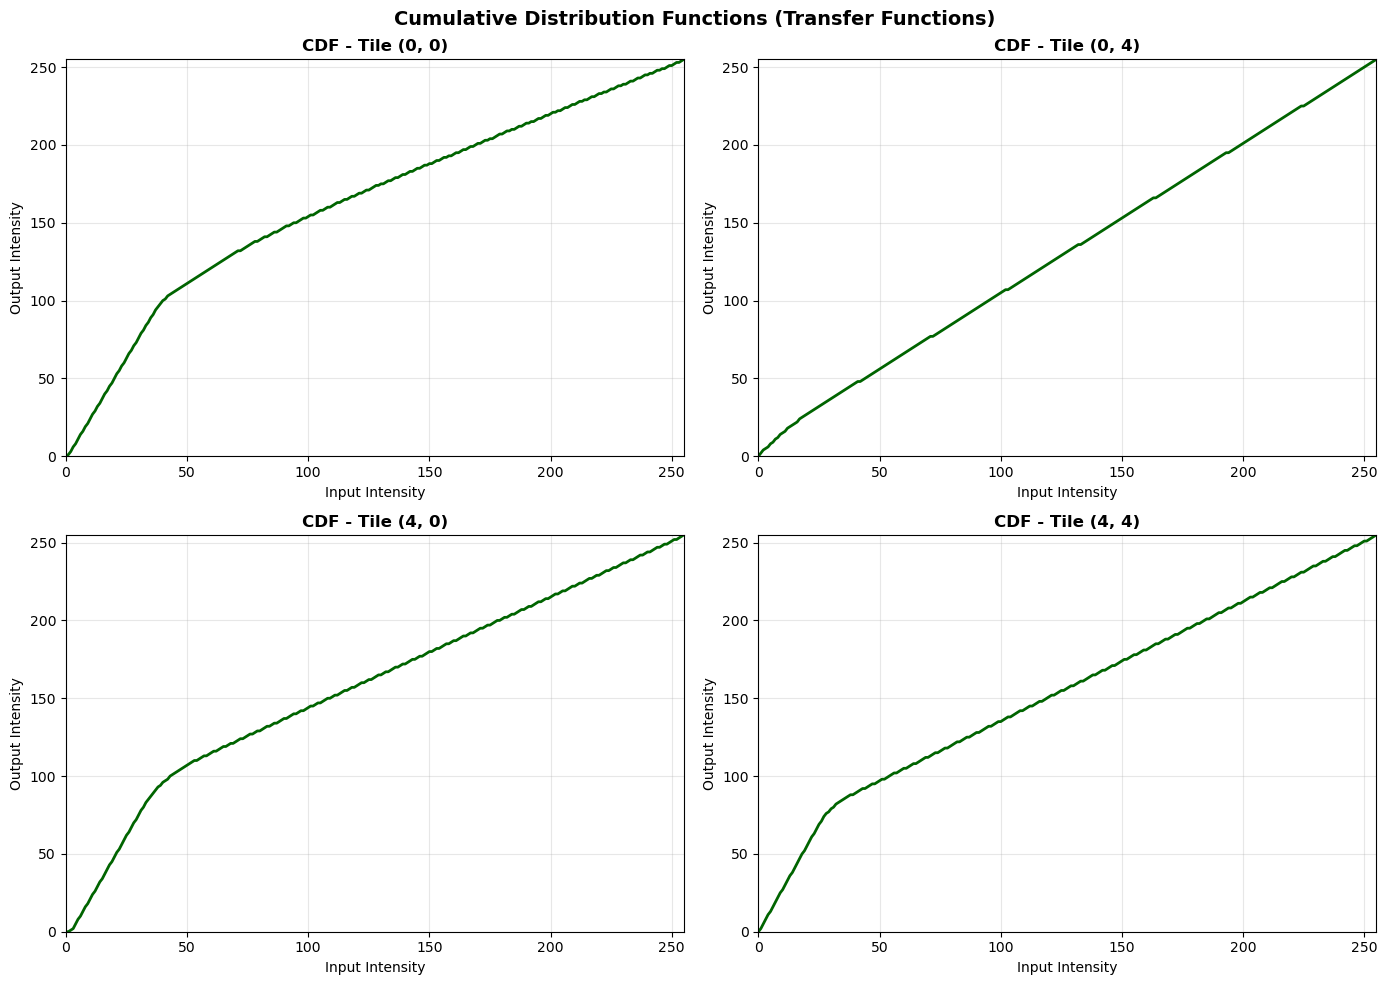


The CDF acts as a transfer function to map input intensities to output intensities.


In [8]:
# Compute CDF for histogram equalization
def compute_cdf(hist):
    """Compute cumulative distribution function from histogram"""
    cdf = hist.cumsum()
    # Normalize to [0, 255]
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    return cdf_normalized.astype(np.uint8)

# Compute CDFs for all tiles after clipping
tile_cdfs = []
for i in range(tile_size[0]):
    row_cdfs = []
    for j in range(tile_size[1]):
        clipped_hist = clip_histogram(tile_histograms[i][j], clip_limit)
        cdf = compute_cdf(clipped_hist)
        row_cdfs.append(cdf)
    tile_cdfs.append(row_cdfs)

print(f"Computed CDFs for all {tile_size[0]} x {tile_size[1]} tiles")

# Visualize CDFs for sample tiles
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (i, j) in enumerate(sample_positions[:4]):
    cdf = tile_cdfs[i][j]
    
    axes[idx].plot(cdf, color='darkgreen', linewidth=2)
    axes[idx].set_title(f'CDF - Tile ({i}, {j})', fontweight='bold')
    axes[idx].set_xlabel('Input Intensity')
    axes[idx].set_ylabel('Output Intensity')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 255])
    axes[idx].set_ylim([0, 255])

plt.suptitle('Cumulative Distribution Functions (Transfer Functions)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nThe CDF acts as a transfer function to map input intensities to output intensities.")

## Step 7: Apply Histogram Equalization to Each Tile

Applied histogram equalization to all tiles


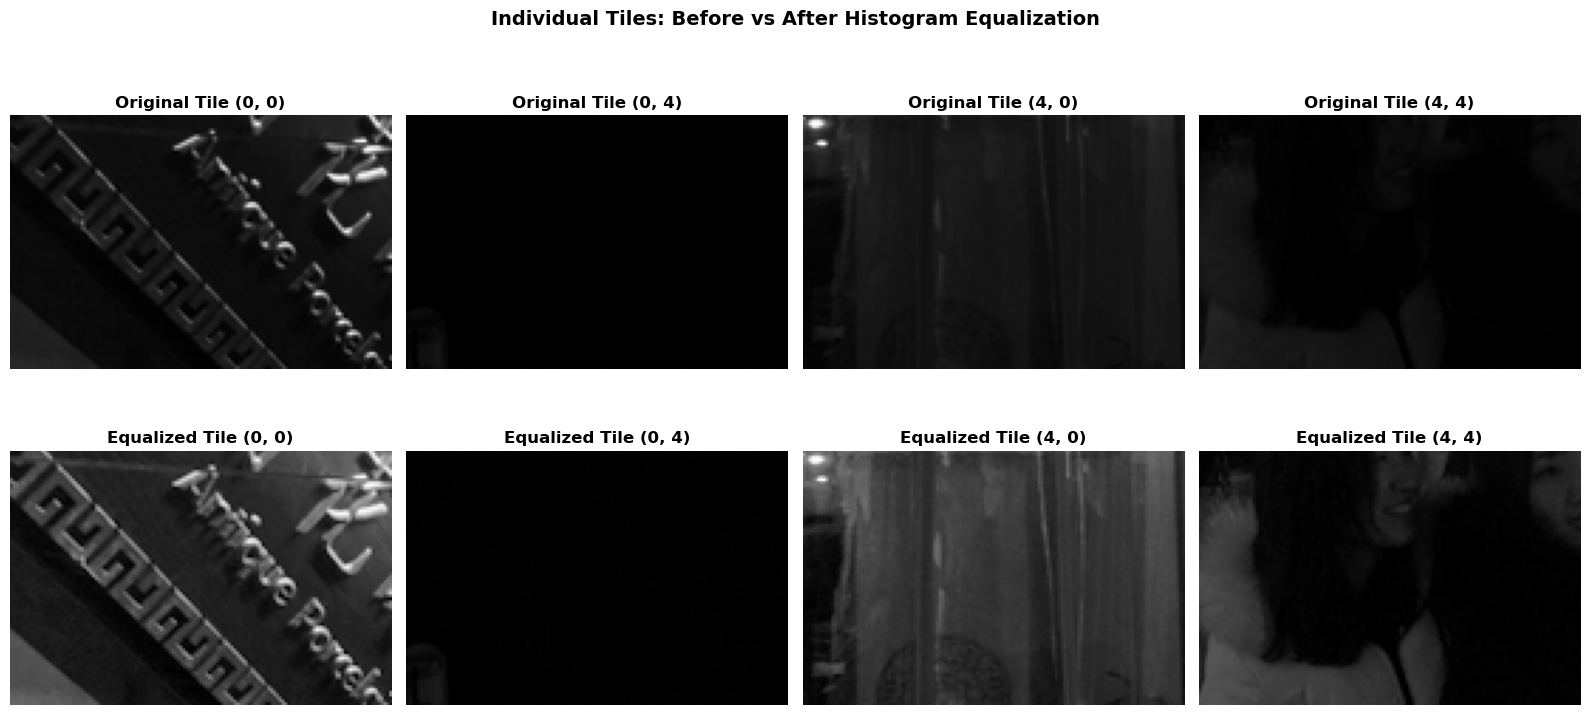

In [9]:
# Apply histogram equalization using CDFs
equalized_tiles = np.zeros_like(image)

for i in range(tile_size[0]):
    for j in range(tile_size[1]):
        # Extract tile
        y_start = i * tile_height
        y_end = (i + 1) * tile_height
        x_start = j * tile_width
        x_end = (j + 1) * tile_width
        
        tile = image[y_start:y_end, x_start:x_end]
        
        # Apply CDF transformation
        cdf = tile_cdfs[i][j]
        equalized_tile = cdf[tile]
        
        equalized_tiles[y_start:y_end, x_start:x_end] = equalized_tile

print("Applied histogram equalization to all tiles")

# Visualize sample equalized tiles
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, (i, j) in enumerate(sample_positions[:4]):
    # Extract tiles
    y_start = i * tile_height
    y_end = (i + 1) * tile_height
    x_start = j * tile_width
    x_end = (j + 1) * tile_width
    
    original_tile = image[y_start:y_end, x_start:x_end]
    equalized_tile = equalized_tiles[y_start:y_end, x_start:x_end]
    
    # Display original tile
    axes[0, idx].imshow(original_tile, cmap='gray', vmin=0, vmax=255)
    axes[0, idx].set_title(f'Original Tile ({i}, {j})', fontweight='bold')
    axes[0, idx].axis('off')
    
    # Display equalized tile
    axes[1, idx].imshow(equalized_tile, cmap='gray', vmin=0, vmax=255)
    axes[1, idx].set_title(f'Equalized Tile ({i}, {j})', fontweight='bold')
    axes[1, idx].axis('off')

plt.suptitle('Individual Tiles: Before vs After Histogram Equalization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 8: Show Result Before Interpolation (Block Artifacts)

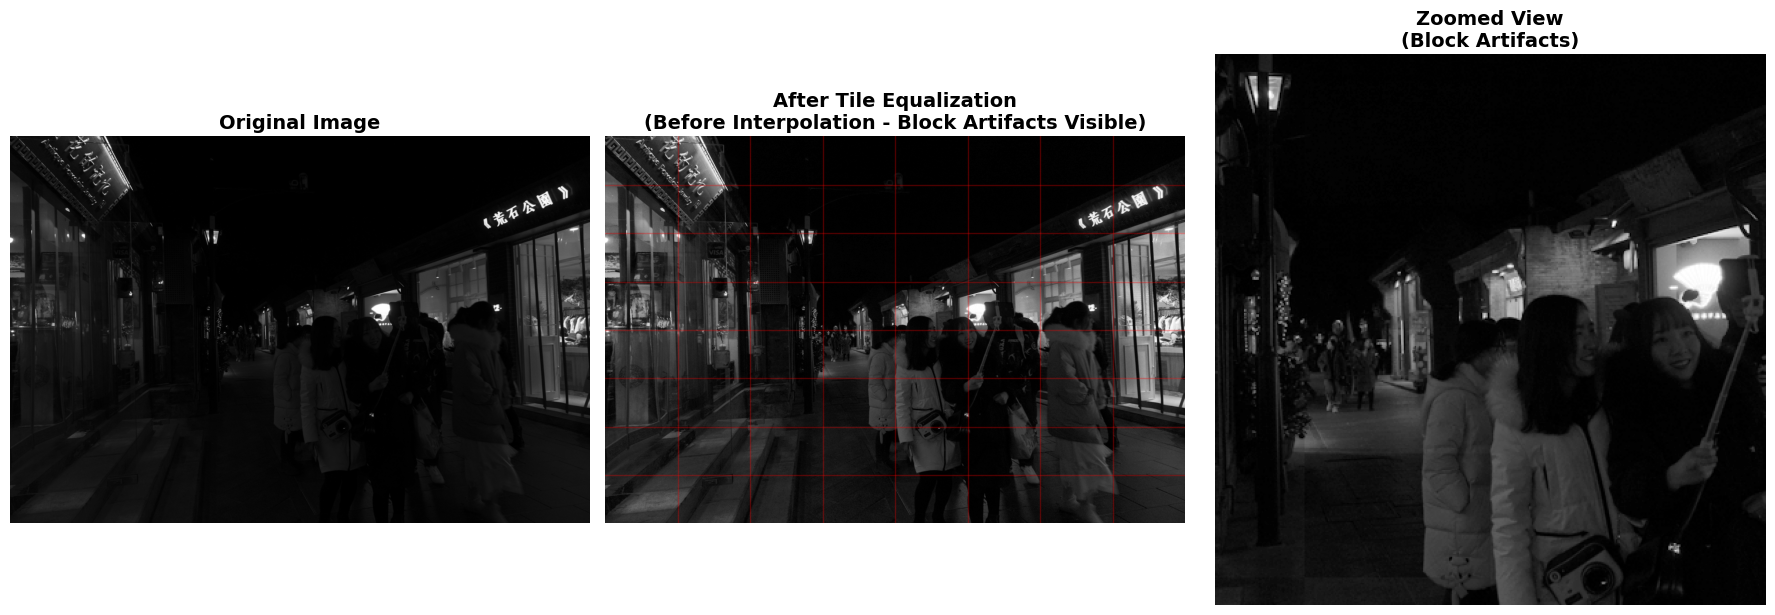

Block artifacts are visible at tile boundaries.
Bilinear interpolation is needed to smooth these transitions.


In [10]:
# Display the result without bilinear interpolation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Equalized without interpolation
axes[1].imshow(equalized_tiles, cmap='gray')
axes[1].set_title('After Tile Equalization\n(Before Interpolation - Block Artifacts Visible)', 
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

# Zoom in to show artifacts
h_center, w_center = image.shape[0] // 2, image.shape[1] // 2
crop_size = 200
axes[2].imshow(equalized_tiles[h_center-crop_size:h_center+crop_size, 
                               w_center-crop_size:w_center+crop_size], cmap='gray')
axes[2].set_title('Zoomed View\n(Block Artifacts)', fontsize=14, fontweight='bold')
axes[2].axis('off')

# Draw grid on zoomed view
for ax in [axes[1]]:
    for i in range(1, tile_size[0]):
        ax.axhline(y=i * tile_height, color='red', linewidth=1, alpha=0.3)
    for j in range(1, tile_size[1]):
        ax.axvline(x=j * tile_width, color='red', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

print("Block artifacts are visible at tile boundaries.")
print("Bilinear interpolation is needed to smooth these transitions.")

## Step 9: Apply Bilinear Interpolation Between Tiles

Applied CLAHE with bilinear interpolation


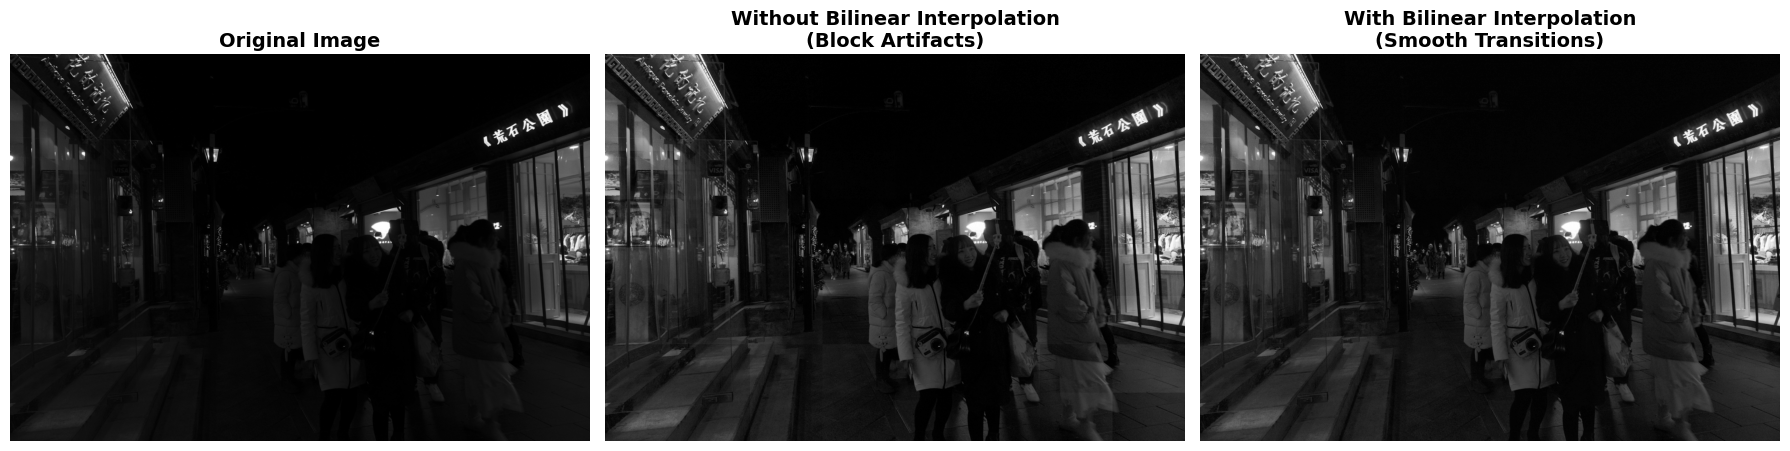


Bilinear interpolation smooths the transitions between tiles, eliminating block artifacts.


In [11]:
# Apply CLAHE using OpenCV (which includes bilinear interpolation)
clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
clahe_result = clahe.apply(image)

print("Applied CLAHE with bilinear interpolation")

# Compare results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Without interpolation
axes[1].imshow(equalized_tiles, cmap='gray')
axes[1].set_title('Without Bilinear Interpolation\n(Block Artifacts)', fontsize=14, fontweight='bold')
axes[1].axis('off')

# With interpolation
axes[2].imshow(clahe_result, cmap='gray')
axes[2].set_title('With Bilinear Interpolation\n(Smooth Transitions)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\nBilinear interpolation smooths the transitions between tiles, eliminating block artifacts.")

## Step 10: Final Result - Before and After Comparison

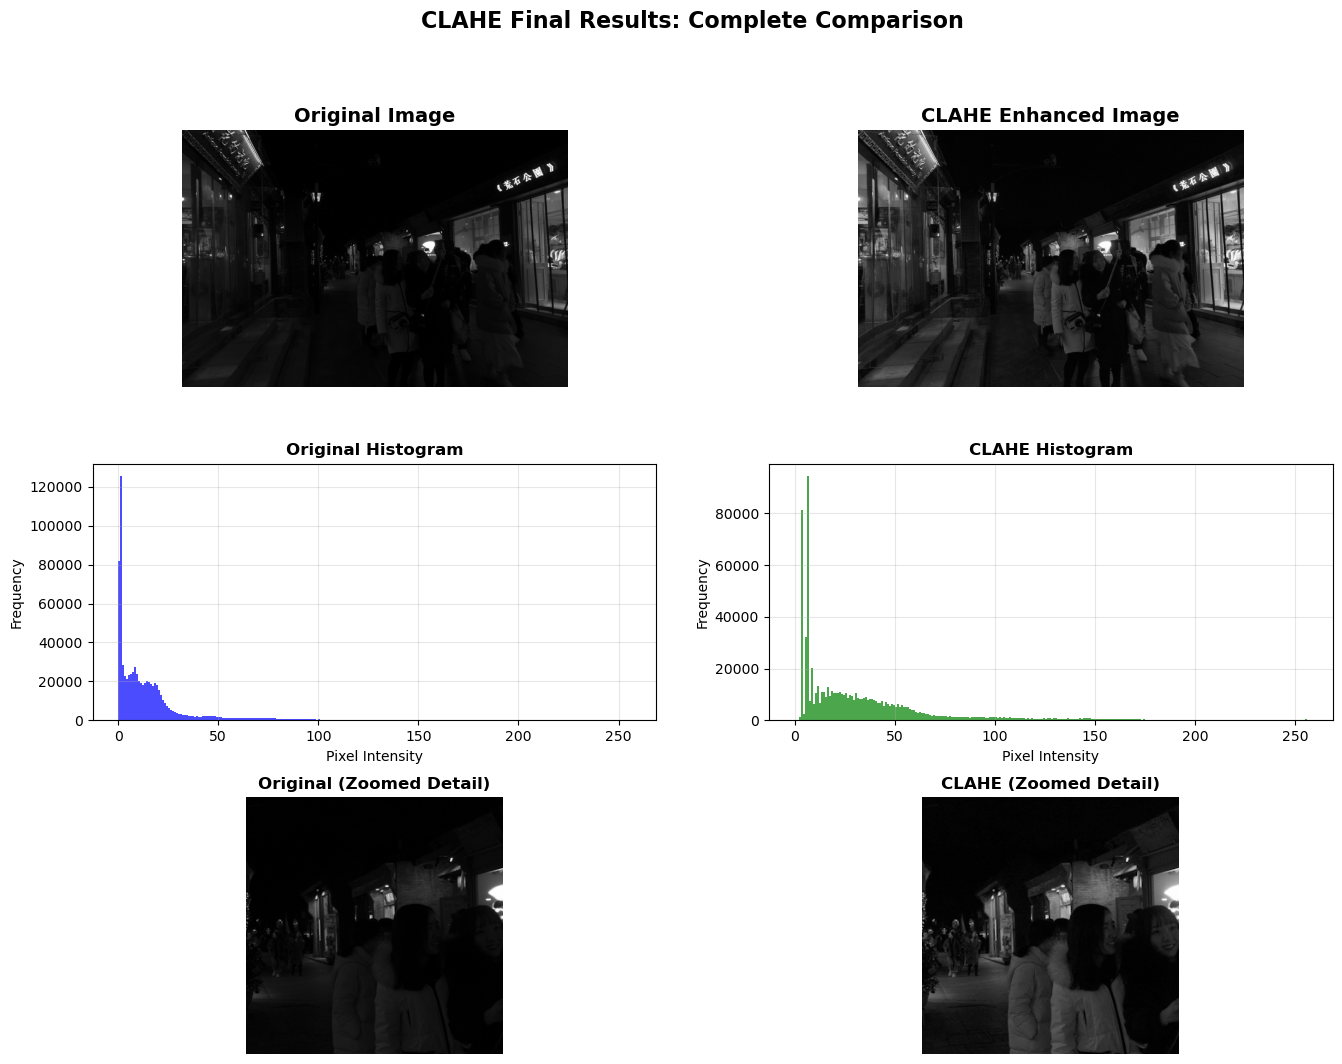


CLAHE PROCESSING COMPLETE

Original Image Statistics:
  Mean: 16.33
  Std: 25.85
  Min: 0
  Max: 255

CLAHE Enhanced Image Statistics:
  Mean: 35.31
  Std: 39.76
  Min: 1
  Max: 255

Parameters Used:
  Tile Grid Size: (8, 8)
  Clip Limit: 2.0
  Number of Tiles: 64


In [12]:
# Final comprehensive comparison
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.2)

# Original image
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=14, fontweight='bold')
ax1.axis('off')

# CLAHE result
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(clahe_result, cmap='gray')
ax2.set_title('CLAHE Enhanced Image', fontsize=14, fontweight='bold')
ax2.axis('off')

# Original histogram
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(image.ravel(), bins=256, range=[0, 256], color='blue', alpha=0.7)
ax3.set_title('Original Histogram', fontsize=12, fontweight='bold')
ax3.set_xlabel('Pixel Intensity')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

# CLAHE histogram
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(clahe_result.ravel(), bins=256, range=[0, 256], color='green', alpha=0.7)
ax4.set_title('CLAHE Histogram', fontsize=12, fontweight='bold')
ax4.set_xlabel('Pixel Intensity')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

# Zoomed comparison - original
ax5 = fig.add_subplot(gs[2, 0])
h_center, w_center = image.shape[0] // 2, image.shape[1] // 2
crop_size = 150
ax5.imshow(image[h_center-crop_size:h_center+crop_size, 
                 w_center-crop_size:w_center+crop_size], cmap='gray')
ax5.set_title('Original (Zoomed Detail)', fontsize=12, fontweight='bold')
ax5.axis('off')

# Zoomed comparison - CLAHE
ax6 = fig.add_subplot(gs[2, 1])
ax6.imshow(clahe_result[h_center-crop_size:h_center+crop_size, 
                        w_center-crop_size:w_center+crop_size], cmap='gray')
ax6.set_title('CLAHE (Zoomed Detail)', fontsize=12, fontweight='bold')
ax6.axis('off')

plt.suptitle('CLAHE Final Results: Complete Comparison', fontsize=16, fontweight='bold')
plt.show()

# Print statistics
print("\n" + "="*60)
print("CLAHE PROCESSING COMPLETE")
print("="*60)
print(f"\nOriginal Image Statistics:")
print(f"  Mean: {image.mean():.2f}")
print(f"  Std: {image.std():.2f}")
print(f"  Min: {image.min()}")
print(f"  Max: {image.max()}")

print(f"\nCLAHE Enhanced Image Statistics:")
print(f"  Mean: {clahe_result.mean():.2f}")
print(f"  Std: {clahe_result.std():.2f}")
print(f"  Min: {clahe_result.min()}")
print(f"  Max: {clahe_result.max()}")

print(f"\nParameters Used:")
print(f"  Tile Grid Size: {tile_size}")
print(f"  Clip Limit: {clip_limit}")
print(f"  Number of Tiles: {tile_size[0] * tile_size[1]}")

## Step 11: Comparison with Different CLAHE Parameters

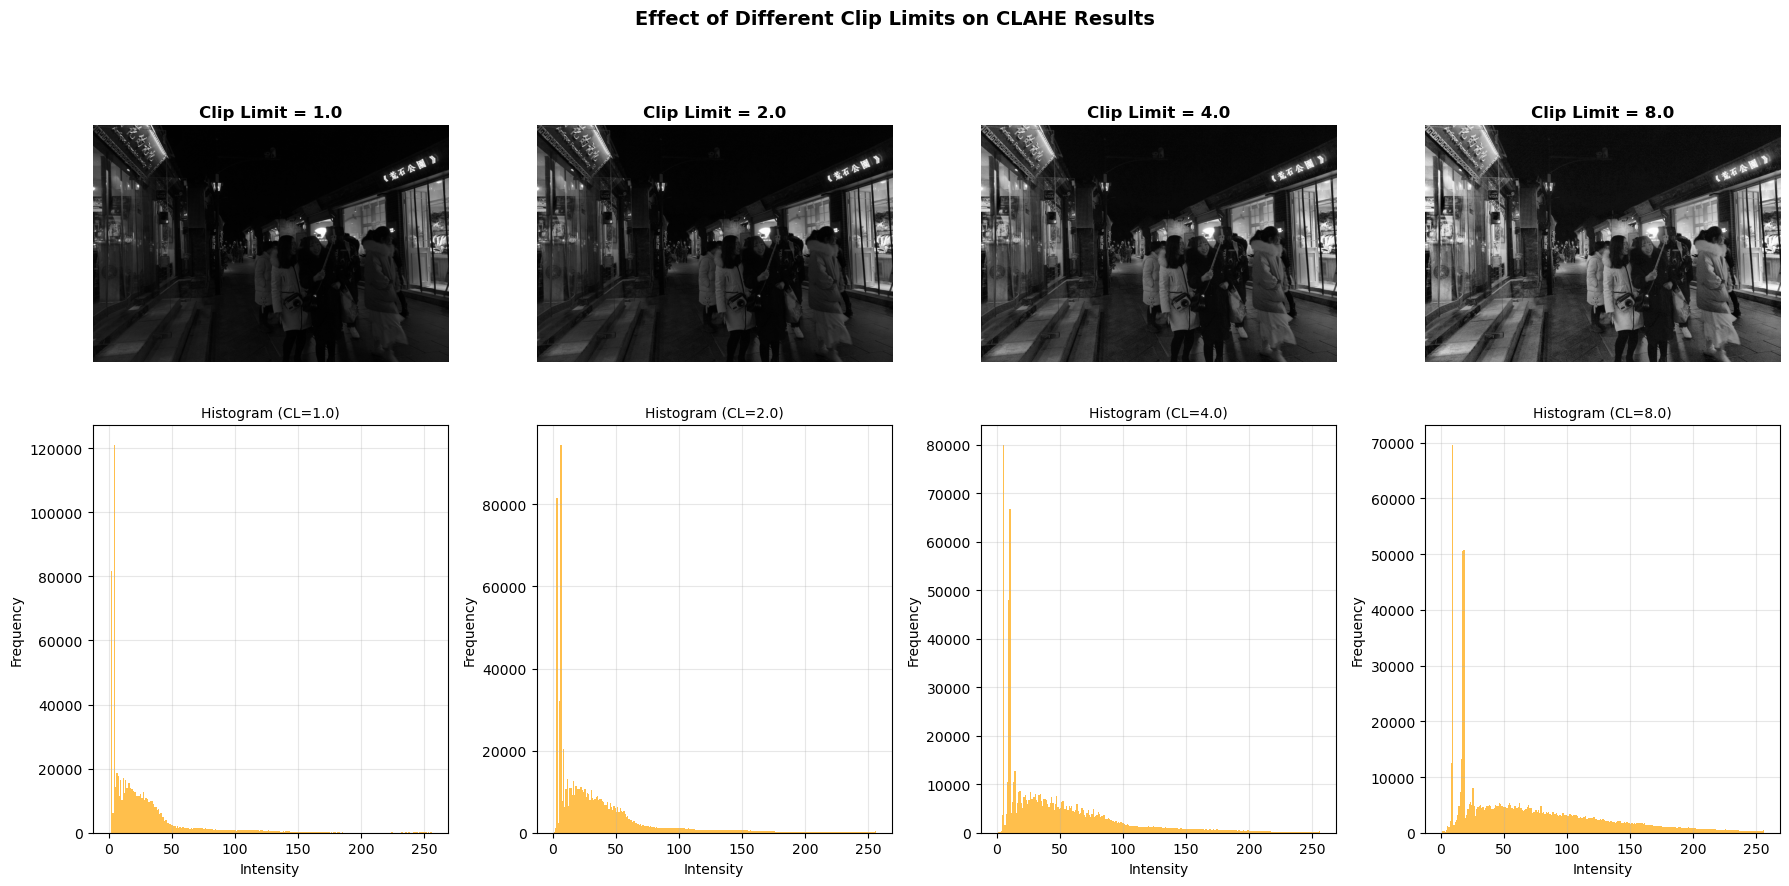


Higher clip limits allow more contrast enhancement but may amplify noise.
Lower clip limits provide gentler enhancement with better noise control.


In [13]:
# Test different clip limits
clip_limits = [1.0, 2.0, 4.0, 8.0]

fig, axes = plt.subplots(2, 4, figsize=(18, 9))

for idx, cl in enumerate(clip_limits):
    clahe_test = cv2.createCLAHE(clipLimit=cl, tileGridSize=tile_size)
    result = clahe_test.apply(image)
    
    # Display image
    axes[0, idx].imshow(result, cmap='gray')
    axes[0, idx].set_title(f'Clip Limit = {cl}', fontsize=12, fontweight='bold')
    axes[0, idx].axis('off')
    
    # Display histogram
    axes[1, idx].hist(result.ravel(), bins=256, range=[0, 256], 
                      color='orange', alpha=0.7)
    axes[1, idx].set_title(f'Histogram (CL={cl})', fontsize=10)
    axes[1, idx].set_xlabel('Intensity')
    axes[1, idx].set_ylabel('Frequency')
    axes[1, idx].grid(True, alpha=0.3)

plt.suptitle('Effect of Different Clip Limits on CLAHE Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nHigher clip limits allow more contrast enhancement but may amplify noise.")
print("Lower clip limits provide gentler enhancement with better noise control.")

## Step 12: Comparison with Different Tile Sizes

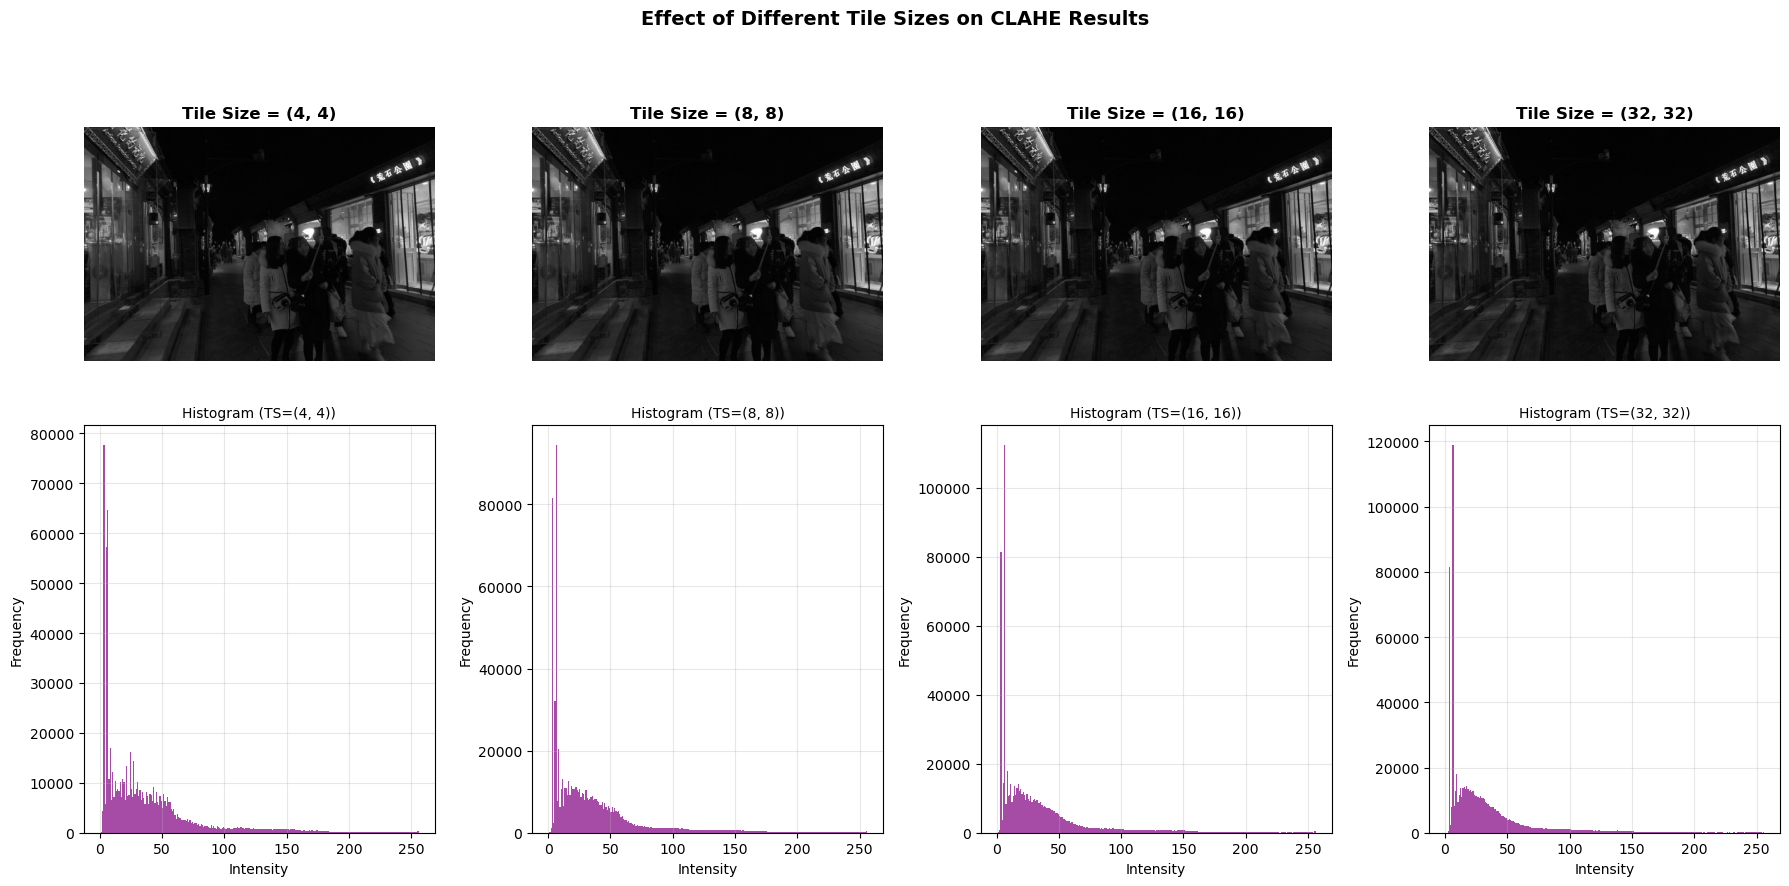


Smaller tiles provide more local adaptation but may create more artifacts.
Larger tiles provide smoother results but less local detail enhancement.


In [14]:
# Test different tile sizes
tile_sizes_test = [(4, 4), (8, 8), (16, 16), (32, 32)]

fig, axes = plt.subplots(2, 4, figsize=(18, 9))

for idx, ts in enumerate(tile_sizes_test):
    clahe_test = cv2.createCLAHE(clipLimit=2.0, tileGridSize=ts)
    result = clahe_test.apply(image)
    
    # Display image
    axes[0, idx].imshow(result, cmap='gray')
    axes[0, idx].set_title(f'Tile Size = {ts}', fontsize=12, fontweight='bold')
    axes[0, idx].axis('off')
    
    # Display histogram
    axes[1, idx].hist(result.ravel(), bins=256, range=[0, 256], 
                      color='purple', alpha=0.7)
    axes[1, idx].set_title(f'Histogram (TS={ts})', fontsize=10)
    axes[1, idx].set_xlabel('Intensity')
    axes[1, idx].set_ylabel('Frequency')
    axes[1, idx].grid(True, alpha=0.3)

plt.suptitle('Effect of Different Tile Sizes on CLAHE Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nSmaller tiles provide more local adaptation but may create more artifacts.")
print("Larger tiles provide smoother results but less local detail enhancement.")

## Summary

### CLAHE Algorithm Steps:

1. **Tile Division**: Divide the image into a grid of small tiles (e.g., 8×8)
2. **Histogram Computation**: Calculate histogram for each tile
3. **Contrast Limiting**: Clip histogram peaks to prevent over-amplification (using clip limit)
4. **Redistribution**: Redistribute clipped pixels uniformly across all intensity levels
5. **CDF Computation**: Calculate cumulative distribution function for each tile
6. **Equalization**: Apply histogram equalization to each tile using its CDF
7. **Bilinear Interpolation**: Smooth transitions between tiles to eliminate block artifacts

### Key Parameters:

- **Tile Grid Size**: Controls local vs global adaptation (smaller = more local)
- **Clip Limit**: Controls the degree of contrast enhancement (higher = more enhancement, more noise)

### Advantages of CLAHE:

- Adaptive to local image characteristics
- Prevents over-amplification of noise
- Enhances local contrast while preserving overall appearance
- Widely used in medical imaging, underwater imaging, and low-light image enhancement